# DATA PREPROCESSING #
I retrieved the data from the TCGA database using an R(Bioconductor) library (the same used in the article). <br />
I had to contact the research group that wrote the article because the description of the data wasn't precise, they helped me and they asked me to not further share the final data, so please keep this in mind. <br />
Here below I first import the necessary libraries, you can notice I also import pyDeepInsight which is necessary to perform the data transformation mentioned in the homonymous article. 

In [1]:
pip install git+git://github.com/alok-ai-lab/DeepInsight.git

  Cloning git://github.com/alok-ai-lab/DeepInsight.git to /tmp/pip-req-build-yomjdqrn
  Running command git clone -q git://github.com/alok-ai-lab/DeepInsight.git /tmp/pip-req-build-yomjdqrn
  Created wheel for DeepInsight: filename=DeepInsight-0.1.0-py3-none-any.whl size=17215 sha256=177ea2cd5840f5debbd038973479dd78ad7c6ea1647b8a9e6d270c1ea807338b
  Stored in directory: /tmp/pip-ephem-wheel-cache-mlc9kb_l/wheels/e4/bc/9d/c483e2a4902573f36c6a2a2e90e247662dada37685d34c1a58
Successfully built DeepInsight


In [2]:
import pandas as pd
import numpy as np
from pyDeepInsight import ImageTransformer, LogScaler
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

import warnings; 
warnings.simplefilter('ignore')

pd.set_option("display.max_rows", None, "display.max_columns", None)

## Gene Expression ##
This file contains the expression values for every sample and for every meaningful gene. Please find the description of "meaningful gene" in the description of the dataset that is present in the article. <br />
This part has been performed in R so here there is just the final result, the values are thus the expression of genes as log2(FPKM+1), hence the "normalized" number of overlapping reads on the gene of interest plus 1 (to avoid log2(0)) reported as log2. 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
gene_expression = pd.read_csv("drive/MyDrive/exp_fpkm_pancan_data_log2plus1.txt", sep = '\t' , header = 0)
print(gene_expression.shape)
gene_expression.head()

(13781, 11093)


TCGA-OR-A5L4-01A-11R-A29S-07  TCGA-OR-A5KX-01A-11R-A29S-07  \
0                      3.593240                      3.399946   
1                      0.318380                      0.035661   
2                      5.020873                      5.446684   
3                      0.995273                      1.244782   
4                      0.569635                      0.979935   

   TCGA-OR-A5JT-01A-11R-A29S-07  TCGA-OR-A5K9-01A-11R-A29S-07  \
0                      3.469919                      2.821973   
1                      0.300530                      0.017393   
2                      5.365337                      5.284905   
3                      1.210194                      1.646438   
4                      0.714145                      1.410976   

   TCGA-OR-A5JV-01A-11R-A29S-07  TCGA-OR-A5KV-01A-11R-A29S-07  \
0                      2.113599                      3.340179   
1                      0.035949                      0.000000   
2                      5.265229                      5.974061   
3                      1.348386                      1.190441   
4                      0.955666                      0.400571   

   TCGA-OR-A5JE-01A-11R-A29S-07  TCGA-OR-A5JC-01A-11R-A29S-07  \
0                      2.882158                      3.261231   
1                      0.146764                      0.038307   
2                      5.647265                      5.348759   
3                      1.145152                      0.801326   
4                      0.735124                      0.473450   

   TCGA-OR-A5LJ-01A-11R-A29S-07  TCGA-OR-A5JW-01A-11R-A29S-07  \
0                      3.454196                      2.908243   
1                      0.181945                      0.127417   
2                      5.727763                      5.894170   
3                      1.010539                      1.279885   
4                      0.687007                      0.431672   

   TCGA-P6-A5OF-01A-11R-A29S-07  TCGA-OR-A5LP-01A-11R-A29S-07  \
0                      3.159882                      3.094900   
1                      0.222623                      0.029675   
2                      5.698284                      5.261293   
3                      1.056437                      1.042447   
4                      0.924020                      0.678057   

   TCGA-P6-A5OG-01A-22R-A29S-07  TCGA-OR-A5KT-01A-11R-A29S-07  \
0                      3.397531                      2.768113   
1                      0.254308                      0.383071   
2                      5.070671                      5.462733   
3                      1.447568                      1.143591   
4                      1.554542                      0.603772   

   TCGA-PK-A5HA-01A-11R-A29S-07  TCGA-OR-A5LD-01A-11R-A29S-07  \
0                      2.752412                      1.993672   
1                      0.016959                      0.034220   
2                      4.529631                      2.888190   
3                      1.259407                      0.743075   
4                      0.619167                      0.539379   

   TCGA-OR-A5K0-01A-11R-A29S-07  TCGA-OR-A5J7-01A-11R-A29S-07  \
0                      3.523672                      2.630742   
1                      0.000000                      0.183266   
2                      5.799800                      4.925747   
3                      0.764762                      1.420499   
4                      0.381176                      1.343572   

   TCGA-OR-A5JL-01A-11R-A29S-07  TCGA-OR-A5JP-01A-11R-A29S-07  \
0                      4.000832                      3.027906   
1                      0.196653                      0.081009   
2                      4.789447                      5.375885   
3                      1.434174                      1.341844   
4                      0.391704                      0.715511   

   TCGA-OR-A5JA-01A-11R-A29S-07  TCGA-PK-A5H8-01A-11R-A29S-07  \
0                      3.033

## Clinical Description ##
Here is reported the clinical analysis of the samples, i.e. what kind of tissues are the 11093 samples from. <br />
This is thus the label of the samples, which should be hot encoded for the neural network (I do that right before applying DeepInsight method). <br />
What is really relevant for us is the primary diagnosis, which reports the kind of cancer (or healty tissue).

In [5]:
clinical = pd.read_csv("drive/MyDrive/exp_fpkm_pancan_clinical.txt", sep = '\t' , header = 0, low_memory = False)
print(clinical.shape)
clinical.head()

(11093, 1494)


sample       patient                       barcode  \
0  TCGA-OR-A5L4-01A  TCGA-OR-A5L4  TCGA-OR-A5L4-01A-11R-A29S-07   
1  TCGA-OR-A5KX-01A  TCGA-OR-A5KX  TCGA-OR-A5KX-01A-11R-A29S-07   
2  TCGA-OR-A5JT-01A  TCGA-OR-A5JT  TCGA-OR-A5JT-01A-11R-A29S-07   
3  TCGA-OR-A5K9-01A  TCGA-OR-A5K9  TCGA-OR-A5K9-01A-11R-A29S-07   
4  TCGA-OR-A5JV-01A  TCGA-OR-A5JV  TCGA-OR-A5JV-01A-11R-A29S-07   

  shortLetterCode           definition classification_of_tumor  \
0              TP  Primary solid Tumor            not reported   
1              TP  Primary solid Tumor            not reported   
2              TP  Primary solid Tumor            not reported   
3              TP  Primary solid Tumor            not reported   
4              TP  Primary solid Tumor            not reported   

  last_known_disease_status                updated_datetime.x  \
0              not reported  2018-09-06T16:27:27.906249-05:00   
1              not reported  2018-09-06T16:27:27.906249-05:00   
2              not reported  2018-09-06T16:27:27.906249-05:00   
3              not reported  2018-09-06T16:27:27.906249-05:00   
4              not reported  2018-09-06T16:27:27.906249-05:00   

            primary_diagnosis tumor_stage  age_at_diagnosis vital_status  \
0  Adrenal cortical carcinoma   stage iii           17819.0        alive   
1  Adrenal cortical carcinoma   stage iii            9298.0        alive   
2  Adrenal cortical carcinoma    stage ii           23794.0        alive   
3  Adrenal cortical carcinoma    stage ii           22596.0         dead   
4  Adrenal cortical carcinoma    stage ii           20319.0        alive   

  morphology  days_to_death  days_to_last_known_disease_status  \
0     8370/3            NaN                                NaN   
1     8370/3            NaN                                NaN   
2     8370/3            NaN                                NaN   
3     8370/3          344.0                                NaN   
4     8370/3            NaN                                NaN   

   created_datetime.x   state.x  days_to_recurrence  \
0                 NaN  released                 NaN   
1                 NaN  released                 NaN   
2                 NaN  released                 NaN   
3                 NaN  released                 NaN   
4                 NaN  released                 NaN   

                           diagnosis_id   tumor_grade  \
0  daede443-5bcb-57a9-aea7-501295b3f32b  not reported   
1  c85c921e-0c49-550a-9fc2-3f015681ff17  not reported   
2  ad613d48-feac-563b-a629-d1e709a0c5c1  not reported   
3  33bd38e3-9ba7-5ce7-8d4e-55d24d6cb657  not reported   
4  c91d6605-334e-53a2-a2ff-504d9d3ef8ba  not reported   

                                          treatments  \
0  list(updated_datetime = "2018-09-06T16:27:27.9...   
1  list(updated_datetime = "2018-09-06T16:27:27.9...   
2  list(updated_datetime = "2018-09-06T16:27:27.9...   
3  list(updated_datetime = "2018-09-06T16:27:27.9...   
4  list(updated_datetime = "2018-09-06T16:27:27.9...   

  tissue_or_organ_of_origin  days_to_birth progression_or_recurrence  \
0   Cortex of adrenal gland       -17819.0              not reported   
1   Cortex of adrenal gland        -9298.0              not reported   
2   Cortex of adrenal gland       -23794.0              not reported   
3   Cortex of adrenal gland       -22596.0              not reported   
4   Cortex of adrenal gland       -20319.0              not reported   

  prior_malignancy site_of_resection_or_biopsy  days_to_last_follow_up  \
0     not reported     Cortex of adrenal gland                   967.0   
1     not reported     Cortex of adrenal gland                  1364.0   
2     not reported     Cortex of adrenal gland                   907.0   
3     not reported     Cortex of adrenal gland                     NaN   
4     not reported     Cortex of adrenal gland                  2023.0   

   cigarettes_per_day  weight                updated_datetime.y  \
0           

### SOME EXAMPLES OF PRIMARY DIAGNOSIS ###

In [ ]:
clinical.loc[:, 'primary_diagnosis'][[1,100,1000,10000,11000]]

1                     Adrenal cortical carcinoma
100                  Transitional cell carcinoma
1000                     Mucinous adenocarcinoma
10000    Papillary carcinoma, follicular variant
11000                Acute myeloid leukemia, NOS
Name: primary_diagnosis, dtype: object

## Gene Annotation ##
This file is not relevant for us, I reported this just for completeness. <br />
Moreover, here the annotation of all 56716 genes is reported, regardless their relevance in this analysis.

In [ ]:
gene_annot = pd.read_csv("./exp_fpkm_pancan_geneannot.txt", sep = '\t' , header = 0)
print(gene_annot.shape)
gene_annot.head()

(56716, 3)


ensembl_gene_id external_gene_name original_ensembl_gene_id
0  ENSG00000000003             TSPAN6       ENSG00000000003.13
1  ENSG00000000005               TNMD        ENSG00000000005.5
2  ENSG00000000419               DPM1       ENSG00000000419.11
3  ENSG00000000457              SCYL3       ENSG00000000457.12
4  ENSG00000000460           C1orf112       ENSG00000000460.15

# Deep Insight #
At this point we already have the data as we need it. <br />
I apply the Deep Insight method to the values to transform the dataframe in an ensemble of images-like matrices, which should be more effectively analyzed by Convolutional Networks.

In [6]:
removals = clinical.loc[:, 'primary_diagnosis'].value_counts().reset_index()
removals = removals[removals['primary_diagnosis'] >= 40]['index'].values
rem_index = clinical.loc[:, 'primary_diagnosis'].isin(removals)
filtered_clinical = clinical[clinical.loc[:, 'primary_diagnosis'].isin(removals)]
column_means = gene_expression.mean()
gene_expression = gene_expression.fillna(column_means)
filtered_gene_expression = gene_expression.transpose()[rem_index.values]

In [ ]:
print("NUMBER OF CLASSES AFTER FILTERING:  ", len(pd.unique(filtered_clinical.loc[:, 'primary_diagnosis'])))
print(pd.unique(filtered_clinical.loc[:, 'primary_diagnosis']))


NUMBER OF CLASSES AFTER FILTERING:   40
['Adrenal cortical carcinoma' 'Papillary transitional cell carcinoma'
 'Transitional cell carcinoma' 'Squamous cell carcinoma, NOS'
 'Papillary adenocarcinoma, NOS' 'Infiltrating duct carcinoma, NOS'
 'Lobular carcinoma, NOS' 'Mucinous adenocarcinoma'
 'Tubular adenocarcinoma' 'Squamous cell carcinoma, keratinizing, NOS'
 'Squamous cell carcinoma, large cell, nonkeratinizing, NOS'
 'Adenocarcinoma, NOS' 'Endometrioid adenocarcinoma, NOS'
 'Cholangiocarcinoma' 'Adenocarcinoma with mixed subtypes'
 'Malignant lymphoma, large B-cell, diffuse, NOS' 'Glioblastoma'
 'Renal cell carcinoma, chromophobe type' 'Clear cell adenocarcinoma, NOS'
 'Mixed glioma' 'Oligodendroglioma, anaplastic' 'Astrocytoma, NOS'
 'Astrocytoma, anaplastic' 'Oligodendroglioma, NOS'
 'Hepatocellular carcinoma, NOS' 'Epithelioid mesothelioma, malignant'
 'Serous cystadenocarcinoma, NOS' 'Pheochromocytoma, NOS'
 'Pheochromocytoma, malignant' 'Leiomyosarcoma, NOS'
 'Dedifferentiated

In [ ]:
filtered_clinical.loc[:, 'primary_diagnosis'].value_counts()

Adenocarcinoma, NOS                                          1762
Squamous cell carcinoma, NOS                                 1230
Infiltrating duct carcinoma, NOS                             1032
Papillary adenocarcinoma, NOS                                 764
Clear cell adenocarcinoma, NOS                                601
Serous cystadenocarcinoma, NOS                                519
Endometrioid adenocarcinoma, NOS                              424
Malignant melanoma, NOS                                       422
Hepatocellular carcinoma, NOS                                 407
Transitional cell carcinoma                                   364
Lobular carcinoma, NOS                                        211
Glioblastoma                                                  168
Mucinous adenocarcinoma                                       155
Acute myeloid leukemia, NOS                                   151
Mixed glioma                                                  133
Astrocytom

In [7]:
le = LabelEncoder()
y = le.fit_transform(filtered_clinical.loc[:, 'primary_diagnosis'])
y = pd.get_dummies(y).values
#print(pd.isnull(clinical).any(1).to_numpy().nonzero()[0].tolist())
X = filtered_gene_expression.values
#print(pd.isnull(gene_expression).any(1).to_numpy().nonzero()[0].tolist())
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 0, stratify = y) 
print("TRAIN SHAPE: ", X_train.shape)

TRAIN SHAPE:  (7693, 13781)


In [8]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.4, stratify = y_test) 
print("\nTEST SHAPE: ", X_test.shape, "\nVAL SHAPE: ", X_val.shape)


TEST SHAPE:  (1026, 13781) 
VAL SHAPE:  (1539, 13781)


In [ ]:
pd.DataFrame(y_train).head()

0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  18  \
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   

   19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  \
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   
3   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

   38  39  
0   1   0  
1   0   0  
2   0   0  
3   0   0  
4   0   0

Here I did the following:
<ul>
  <li>Hot encoded clinical 'primary_diagnosis' values set as y (labels)</li>
  <li>Filled NaN in gene_expression with column means</li>
  <li>Set as X the transposed matrix of gene_expression values</li>
  <li>Divided X and y in train and test set</li>
</ul>

## Applying the method ##
First of all, I normalize the data with the LogScaler.

In [9]:
ln = LogScaler()
X_train_norm = ln.fit_transform(X_train)
X_test_norm = ln.transform(X_test)
X_val_norm = ln.transform(X_val)

Then I initialize the image transformer ImageTransformer. <br />
(I used the default values proposed by the guide of the library)

In [10]:
it = ImageTransformer(feature_extractor = 'tsne', 
                      pixels = 100, random_state = 0, 
                      n_jobs = -1)

Train image transformer on training data. Setting plot=True results in at a plot showing the reduced features (blue points), convex full (red), and minimum bounding rectagle (green) prior to rotation.

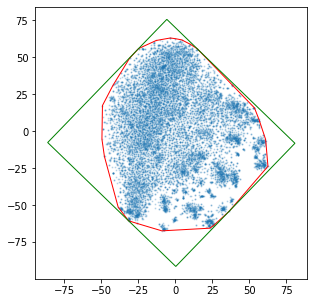

In [ ]:
plt.figure(figsize=(5, 5))
it.fit(X_train_norm, plot=True)

The feature density matrix can be extracted from the trained transformer in order to view overall feature overlap.

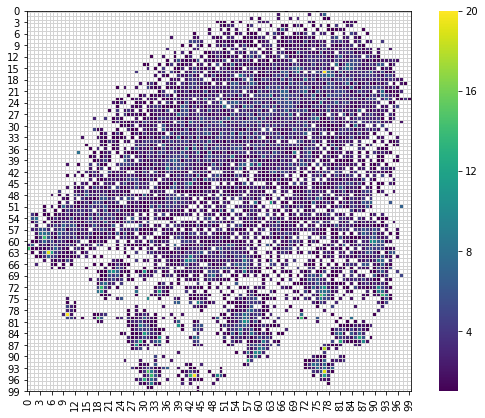

In [ ]:
fdm = it.feature_density_matrix()
fdm[fdm == 0] = np.nan

plt.figure(figsize=(10, 7))

ax = sns.heatmap(fdm, cmap="viridis", linewidths=0.01, 
                 linecolor="lightgrey", square=True)
for _, spine in ax.spines.items():
    spine.set_visible(True)

It is possible to update the pixel size without retraining (good to know).

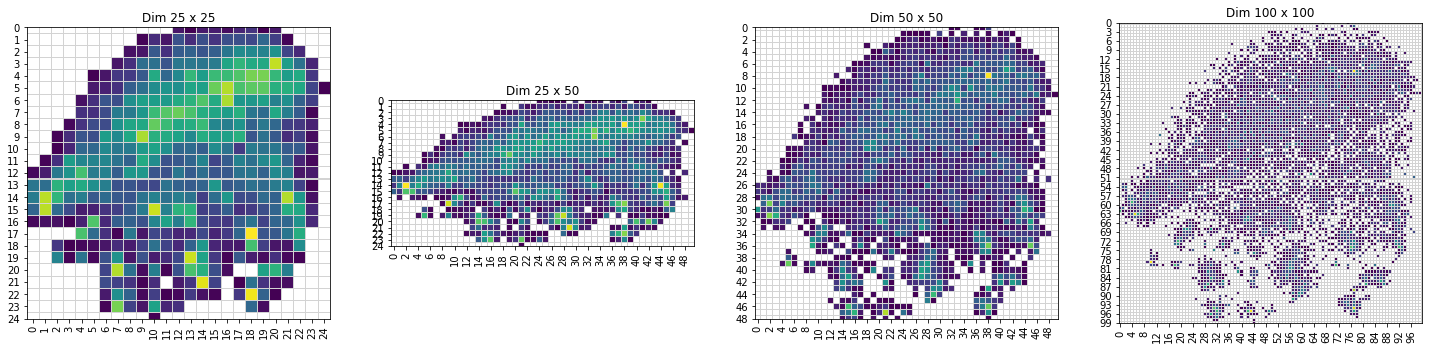

In [ ]:
px_sizes = [25, (25, 50), 50, 100]

fig, ax = plt.subplots(1, len(px_sizes), figsize=(25, 7))
for ix, px in enumerate(px_sizes):
    it.pixels = px
    fdm = it.feature_density_matrix()
    fdm[fdm == 0] = np.nan
    cax = sns.heatmap(fdm, cmap="viridis", linewidth=0.01, 
                      linecolor="lightgrey", square=True, 
                      ax=ax[ix], cbar=False)
    cax.set_title('Dim {} x {}'.format(*it.pixels))
    for _, spine in cax.spines.items():
        spine.set_visible(True)

it.pixels = 100

The trained transformer can then be used to transform sample data to image matricies.

In [11]:
mat_train = it.fit_transform(X_train_norm) # This fits and transform the data

### Image matrices of four samples of the training set ###

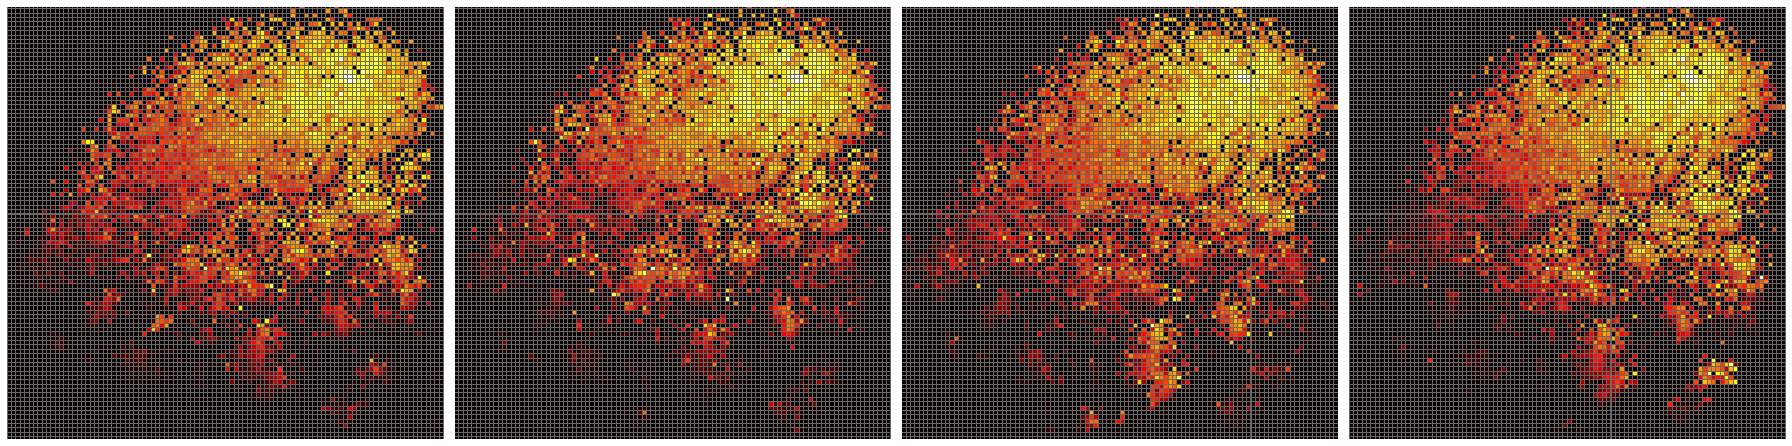

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(25, 7))
n = 0
for i in [1,100,1000,2000]:
    cax = sns.heatmap(mat_train[i][:,:,0], cmap='hot',
                      linewidth=0.01, linecolor='dimgrey',
                      square=True, ax=ax[n], cbar=False)
    n += 1
    cax.axis('off')
plt.tight_layout()

### Image matrices of four samples of the test set ###

In [12]:
mat_test = it.transform(X_test_norm) # This uses pre-fitted model to transform the data

In [13]:
mat_val = it.transform(X_val_norm)

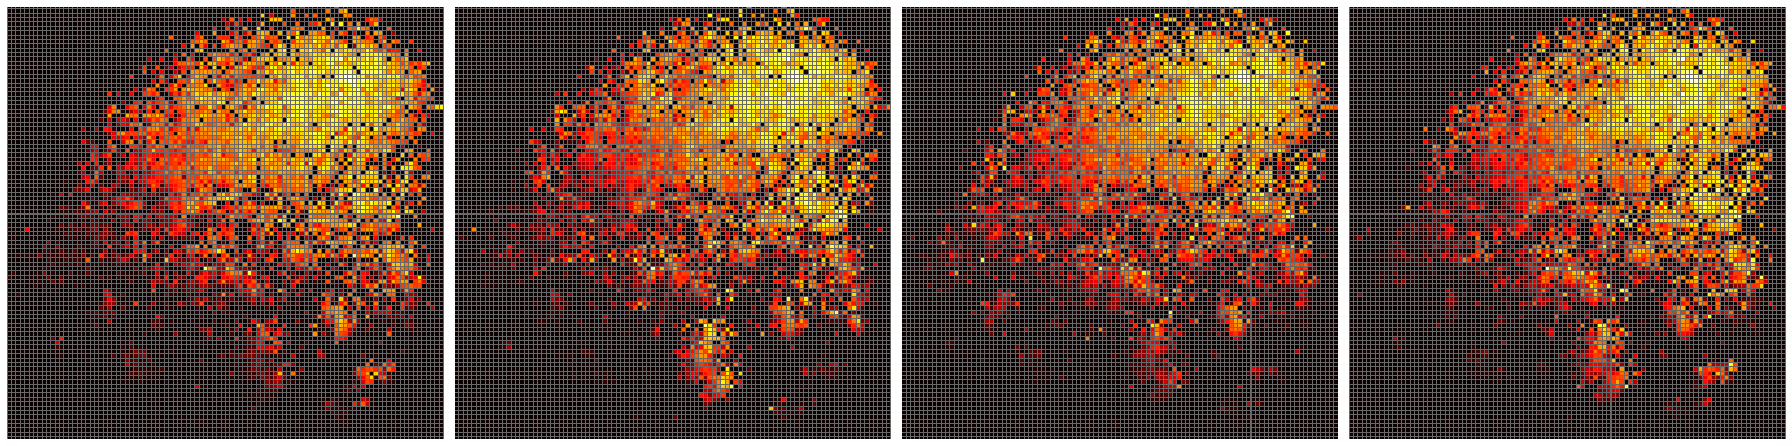

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(25, 7))
n = 0
for i in [1,100,1000,500]:
    cax = sns.heatmap(mat_test[i][:,:,0], cmap='hot',
                      linewidth=0.01, linecolor='dimgrey',
                      square=True, ax=ax[n], cbar=False)
    n += 1
    cax.axis('off')
plt.tight_layout()

## At this point we have our images. These images matrices can then be used as impute for Convolutional Neural Network models. ##

In [14]:
import tensorflow as tf
from tensorflow.keras.metrics import CategoricalAccuracy, Accuracy, Precision, Recall
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Input, concatenate, ReLU, AveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from  tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import pydot

In [ ]:
print(y_test.shape)
print(y_val.shape)
print(y_train.shape)

(1026, 40)
(1539, 40)
(7693, 40)


In [66]:
# 1D model
img_cols = len(X_train_norm[0])
input_X_train = X_train_norm.reshape(X_train_norm.shape[0],1,img_cols,1)
input_X_test = X_test_norm.reshape(X_test_norm.shape[0],1,img_cols,1)
input_X_val = X_val_norm.reshape(X_val_norm.shape[0],1,img_cols,1)
input_shape = (1,img_cols,1)

model_1d = Sequential()
model_1d.add(Conv2D(64,kernel_size=(1,71),strides=(1,1),input_shape=input_shape))
model_1d.add(Dropout(rate=0.2))
model_1d.add(Dense(128,activation='relu'))
model_1d.add(Dropout(rate=0.2))
model_1d.add(MaxPooling2D(1,2))
model_1d.add(Flatten())
model_1d.add(Dense(128,activation='relu'))
model_1d.add(Dense(40,activation='softmax'))
model_1d.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['categorical_accuracy'])
callbacks = [EarlyStopping(monitor='categorical_accuracy',patience=3,verbose=0)]

model_1d.summary()

In [ ]:
# plot model architecture
plot_model(model_1d, show_shapes=True, to_file='model_1d.png')

In [ ]:
history = model_1d.fit(input_X_train,y_train,batch_size=64,epochs=50,verbose=1,
                       callbacks=callbacks,validation_data=(input_X_val,y_val))
scores = model_1d.evaluate(input_X_test,y_test,verbose=1)
y_score = model_1d.predict(input_X_test)
print("%s: %.2f%%" % (model_1d.metrics_names[1],scores[1]*100))

In [ ]:
from sklearn.metrics import classification_report
y_pred = model_1d.predict(input_X_test, batch_size=128, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
y_test_bool = np.argmax(y_test, axis=1)

print(classification_report(y_test_bool, y_pred_bool))
y_1d_t = y_test_bool==y_pred_bool

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [76]:
# 2D Vanilla model
# DeepInsight
img_rows, img_cols = len(mat_train[0][0]), len(mat_train[0])
input_shape = (img_rows,img_cols,3)

model_vanilla = Sequential()
model_vanilla.add(Conv2D(32,kernel_size=(10,10),strides=(2,2),input_shape=input_shape))
model_vanilla.add(Activation(tf.keras.layers.LeakyReLU(alpha=0.01)))
model_vanilla.add(MaxPooling2D(2,2))
model_vanilla.add(Flatten())
model_vanilla.add(Dense(64,activation=tf.keras.layers.LeakyReLU(alpha=0.01))) #
model_vanilla.add(Dropout(rate=0.3))
model_vanilla.add(Dense(128,activation=tf.keras.layers.LeakyReLU(alpha=0.01))) #, kernel_regularizer='l1'
model_vanilla.add(Dropout(rate=0.6))
model_vanilla.add(Dense(40,activation='softmax'))
model_vanilla.compile(loss='categorical_crossentropy',optimizer='RMSprop',
                      metrics=[CategoricalAccuracy()])
callbacks = [EarlyStopping(monitor='categorical_accuracy',patience=3,verbose=0)]

model_vanilla.summary()

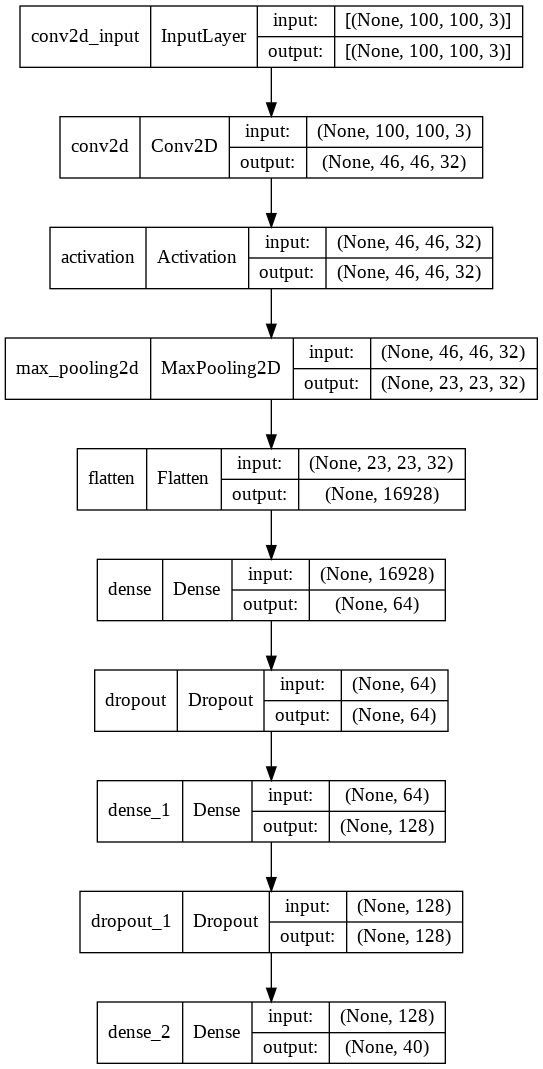

In [ ]:
# plot model architecture
plot_model(model_vanilla, show_shapes=True, to_file='model_vanilla.png')

In [ ]:
history = model_vanilla.fit(mat_train,y_train,batch_size=128,epochs=50,verbose=1,
                            callbacks=callbacks,validation_data=(mat_val,y_val))
scores = model_vanilla.evaluate(mat_test,y_test,verbose=1)
y_score = model_vanilla.predict(mat_test)
print("%s: %.2f%%" % (model_vanilla.metrics_names[1],scores[1]*100))

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
from sklearn.metrics import classification_report
y_pred = model_vanilla.predict(mat_test, batch_size=128, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
y_test_bool = np.argmax(y_test, axis=1)

print(classification_report(y_test_bool, y_pred_bool))
y_v_t = y_test_bool==y_pred_bool

In [83]:
# Hybrid model
# Deep Insight
img_rows, img_cols = len(mat_train[0][0]), len(mat_train[0])
input_shape = (img_rows,img_cols,3)
input_img = Input(input_shape)

tower_1 = Conv2D(32,(1,100),activation='relu')(input_img)
tower_1 = Dropout(rate=0.4)(tower_1)
tower_1 = MaxPooling2D(1,2)(tower_1)
tower_1 = Flatten()(tower_1)

tower_2 = Conv2D(32,(100,1),activation='relu')(input_img)
tower_2 = Dropout(rate=0.4)(tower_2)
tower_2 = MaxPooling2D(1,2)(tower_2)
tower_2 = Flatten()(tower_2)

output = concatenate([tower_1,tower_2],axis=1)
out1 = Dropout(0.5)(output)
out2 = Dense(128,activation=tf.keras.layers.LeakyReLU(alpha=0.01))(out1)
last_layer = Dense(40,activation='softmax')(out2)

model_hybrid = Model([input_img],last_layer)
model_hybrid.output_shape

model_hybrid.compile(loss='categorical_crossentropy',optimizer='RMSprop',metrics=['categorical_accuracy'])
callbacks = [EarlyStopping(monitor='categorical_accuracy',patience=3,verbose=0)]

#model_hybrid.summary()

In [ ]:
history = model_hybrid.fit(mat_train,y_train,batch_size=128,epochs=50,verbose=0,
                           callbacks=callbacks,validation_data=(mat_val,y_val))
scores = model_hybrid.evaluate(mat_test,y_test,verbose=1)
y_score = model_hybrid.predict(mat_test)
print("%s: %.2f%%" % (model_hybrid.metrics_names[1],scores[1]*100))

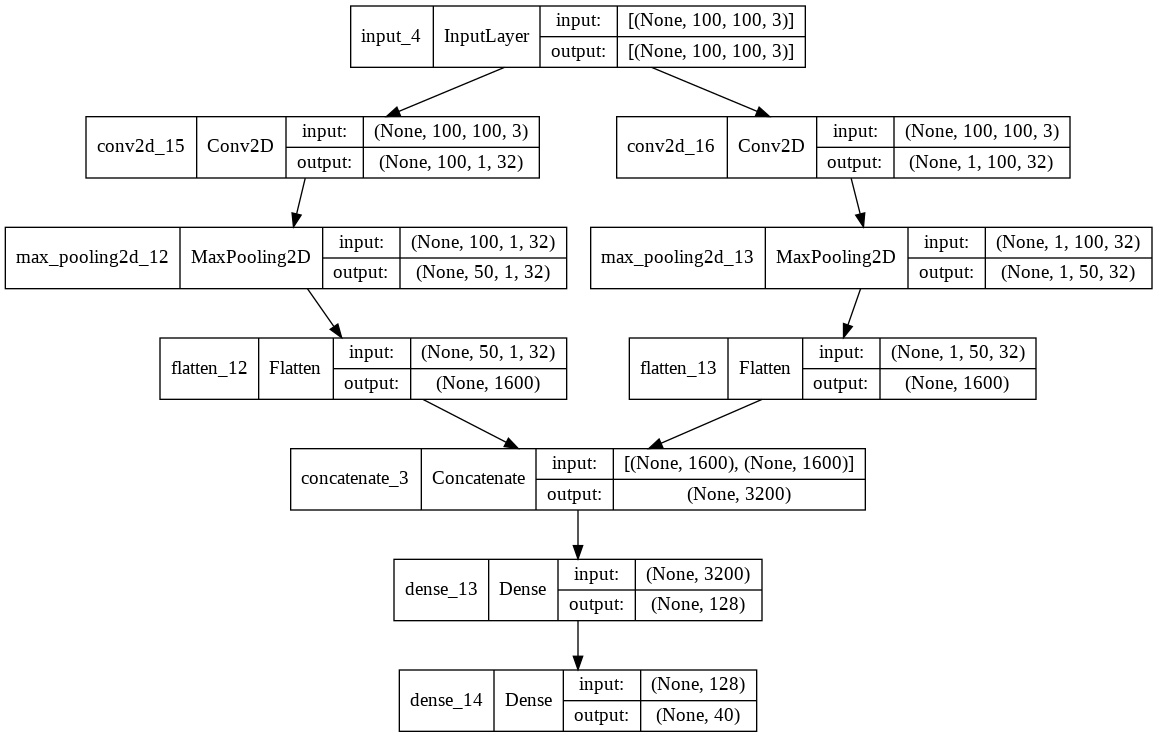

In [ ]:
plot_model(model_hybrid, show_shapes=True, to_file='model_hybrid.png')

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
from sklearn.metrics import classification_report
y_pred = model_hybrid.predict(mat_test, batch_size=128, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
y_test_bool = np.argmax(y_test, axis=1)

print(classification_report(y_test_bool, y_pred_bool))
y_h_t = y_test_bool==y_pred_bool

## ONE INCEPTION MODULE ## 

In [95]:
# function for creating a projected inception module
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu', kernel_regularizer='l1')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu', kernel_regularizer='l1')(layer_in)
    conv3 = Dropout(rate=0.4)(conv3)
    conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu', kernel_regularizer='l1')(conv3)
    
    # 5x5 conv
    conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu', kernel_regularizer='l1')(layer_in)
    conv5 = Dropout(rate=0.4)(conv5)
    conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu', kernel_regularizer='l1')(conv5)
    
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    pool = Conv2D(f4_out, (1,1), padding='same', activation='relu', kernel_regularizer='l1')(pool)
    # concatenate filters, assumes filters/channels last
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out

X_train_img = mat_train
X_test_img = mat_test
X_val_img = mat_val

In [96]:
# define model input
img_rows, img_cols = len(X_train_img[0][0]), len(X_train_img[0])
input_shape = (img_rows,img_cols,3)
input_img = Input(shape = input_shape)
#visible = Input(shape=(256, 256, 3))
# add inception block 1
layer = inception_module(input_img, 64, 96, 128, 16, 32, 32)
#OUTPUT
D1_layer = Dropout(rate=0.6)(layer)
d_layer = Dense(64,activation='relu',kernel_regularizer='l1')(D1_layer)
D2_layer = Dropout(rate=0.4)(d_layer)
last_layer = Flatten()(D2_layer)
output = Dense(40,activation='softmax')(last_layer)
# create model
model = Model(inputs=[input_img], outputs=output)
# summarize model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 100, 100, 96  384         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_8 (Conv2D)              (None, 100, 100, 16  64          ['input_2[0][0]']                
                                )                                                           

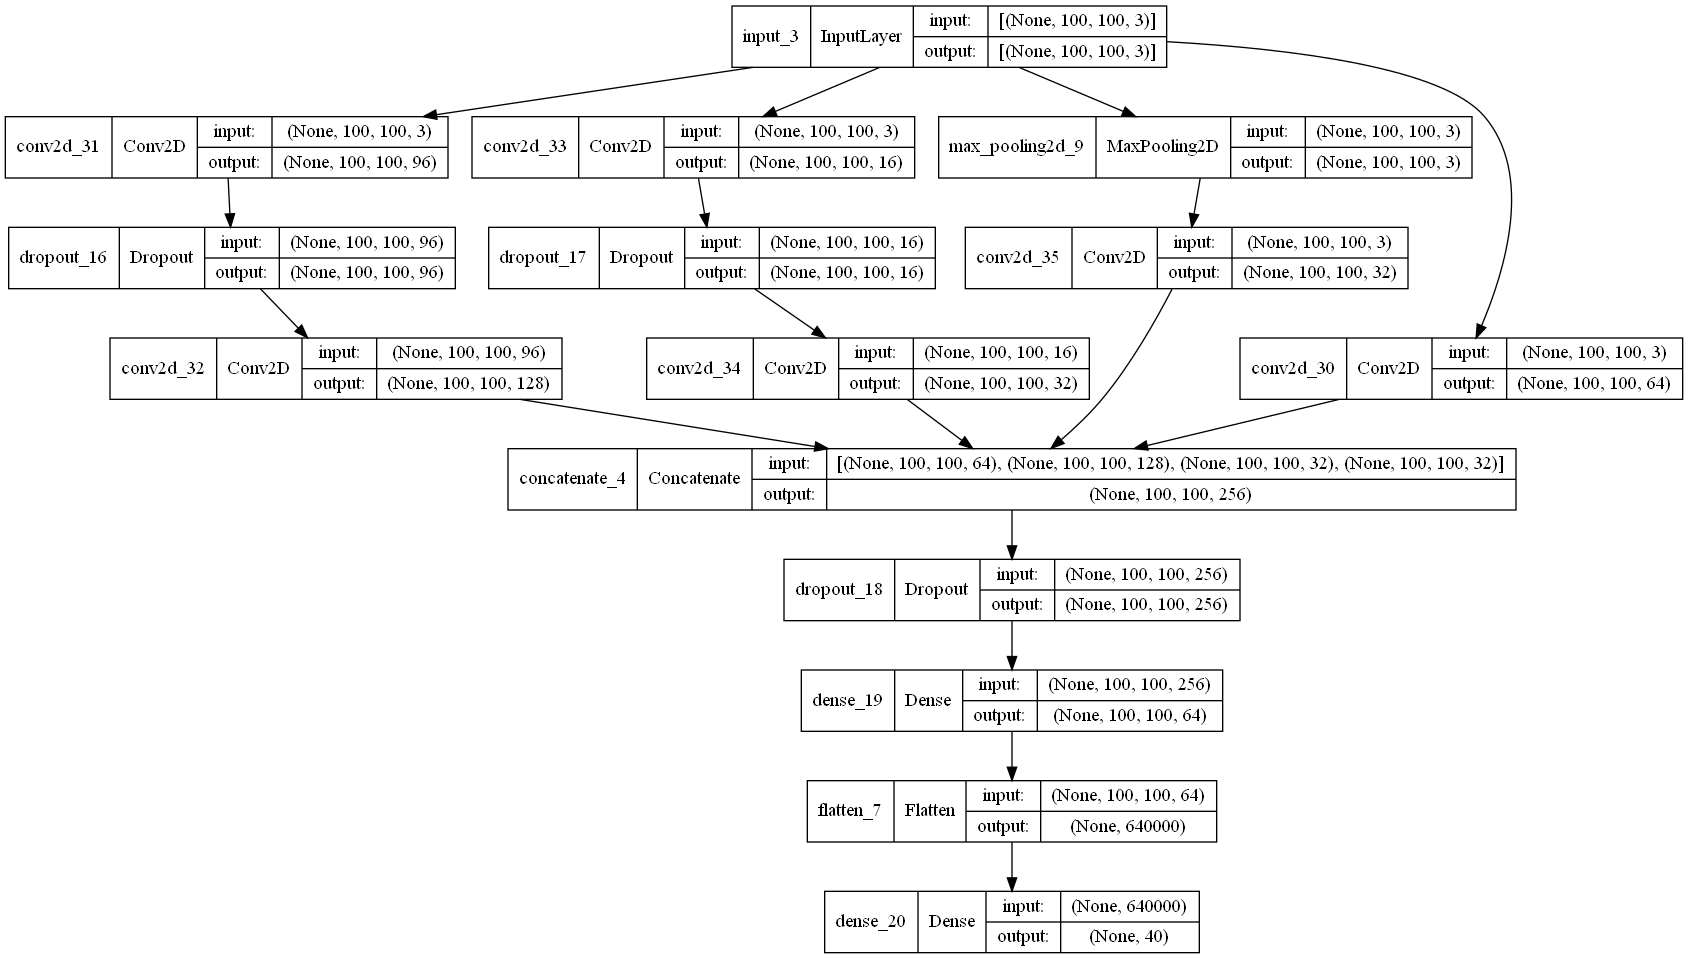

In [ ]:
# plot model architecture
plot_model(model, show_shapes=True, to_file='small_inception.png')

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['categorical_accuracy'])
callbacks = [EarlyStopping(monitor='categorical_accuracy',patience=3,verbose=0)]

history = model.fit(X_train_img,y_train,batch_size=128,epochs=50,verbose=1,validation_data=(X_val_img,y_val))
scores = model.evaluate(X_test_img,y_test,verbose=1)
y_score = model.predict(X_test_img)
print("%s: %.2f%%" % (model.metrics_names[1],scores[1]*100))

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict(mat_test, batch_size=128, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
y_test_bool = np.argmax(y_test, axis=1)

print(classification_report(y_test_bool, y_pred_bool))
y_inc_t = y_test_bool==y_pred_bool

In [ ]:
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import confusion_matrix

print("1D vs Vanilla:")
print(mcnemar(confusion_matrix(y_1d_t,y_v_t),exact=False,correction=False))
print("\n1D vs hybrid:")
print(mcnemar(confusion_matrix(y_1d_t,y_h_t),exact=False,correction=False))
print("\n1D vs Inception:")
print(mcnemar(confusion_matrix(y_1d_t,y_inc_t),exact=False,correction=False))
print("\nVanilla vs hybrid:")
print(mcnemar(confusion_matrix(y_v_t,y_h_t),exact=False,correction=False))
print("\nVanilla vs Inception:")
print(mcnemar(confusion_matrix(y_v_t,y_inc_t),exact=False,correction=False))
print("\nhybrid vs Inception:")
print(mcnemar(confusion_matrix(y_h_t,y_inc_t),exact=False,correction=False))

# ResNet #

In [ ]:
# Experiment ResNet
import keras
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Flatten
from keras.models import Model

resnet = tf.keras.applications.ResNet50(include_top=False,weights=None,input_shape=(100,100,3),pooling=None)
output = Flatten()(resnet.output)
out1 = Dense(40)(output)
model = Model(inputs=resnet.input,outputs=out1)

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['categorical_accuracy'])
callbacks = [EarlyStopping(monitor='categorical_accuracy',patience=3,verbose=0)]
model.summary()

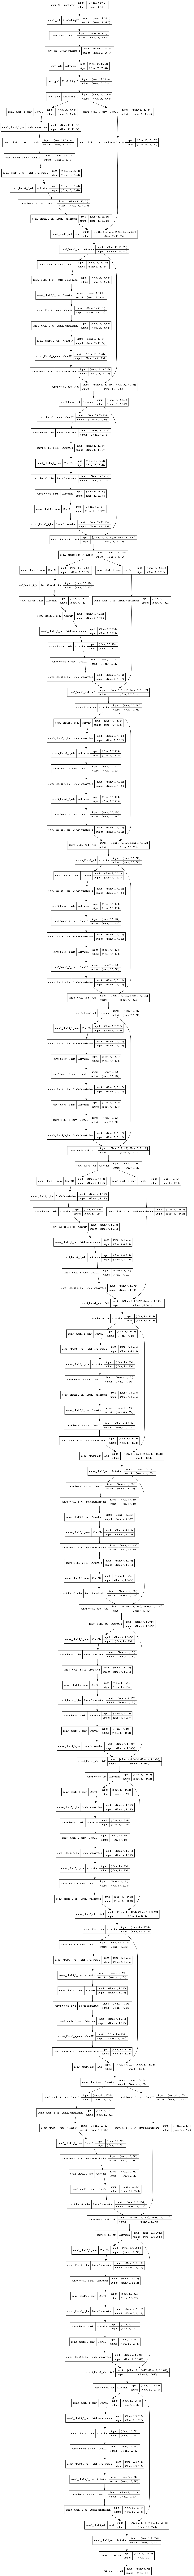

In [ ]:
# plot model architecture
plot_model(model, show_shapes=True, to_file='ResNet.png')

In [ ]:
history = model.fit(mat_train,y_train,batch_size=128,epochs=50,verbose=0,validation_data=(mat_val,y_val))
scores = model.evaluate(mat_test,y_test,verbose=0)
y_score = model.predict(mat_test)
print("%s: %.2f%%" % (model.metrics_names[1],scores[1]*100))

# SqueezeNet #

In [ ]:
def fire_module(input_layer,s1,e1,e3):
    s1x = Conv2D(s1,kernel_size = 1, padding = 'same')(input_layer)
    s1x = ReLU()(s1x)
    e1x = Conv2D(e1,kernel_size = 1, padding = 'same')(s1x)
    e3x = Conv2D(e3,kernel_size = 3, padding = 'same')(s1x)
    conc = concatenate([e1x,e3x])
    out = ReLU()(conc)
    return out

In [ ]:
def SqueezeNet(input_shape, nclasses):
    input_img = Input(input_shape)
    layer = Conv2D(96,kernel_size=(7,7),strides=(2,2),padding='same')(input_img)
    layer = MaxPooling2D(pool_size=(3,3), strides = (2,2))(layer)
    layer = fire_module(layer, s1 = 16, e1 = 64, e3 = 64) #2
    layer = fire_module(layer, s1 = 16, e1 = 64, e3 = 64) #3
    layer = fire_module(layer, s1 = 32, e1 = 128, e3 = 128) #4
    layer = MaxPooling2D(pool_size=(3,3), strides = (2,2))(layer)
    layer = fire_module(layer, s1 = 32, e1 = 128, e3 = 128) #5
    layer = fire_module(layer, s1 = 48, e1 = 192, e3 = 192) #6
    layer = fire_module(layer, s1 = 48, e1 = 192, e3 = 192) #7
    layer = fire_module(layer, s1 = 64, e1 = 256, e3 = 256) #8
    layer = MaxPooling2D(pool_size=(3,3), strides = (2,2))(layer)
    layer = fire_module(layer, s1 = 64, e1 = 256, e3 = 256) #9
    layer = Dropout(0.5)(layer)
    layer = Conv2D(nclasses,kernel_size = 1)(layer)
    layer = AveragePooling2D(pool_size=(13,13))(layer)
    layer = Dense(64,activation='relu')(layer)
    layer = Flatten()(layer)
    output = Dense(40,activation='softmax')(layer)
    model = Model([input_img], output)
    return model

In [ ]:
model = SqueezeNet((256,256,3), 40) #

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['categorical_accuracy'])
callbacks = [EarlyStopping(monitor='categorical_accuracy',patience=3,verbose=0)]
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_314 (Conv2D)            (None, 128, 128, 96  14208       ['input_35[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d_104 (MaxPooling2  (None, 63, 63, 96)  0           ['conv2d_314[0][0]']             
 D)                                                                                         

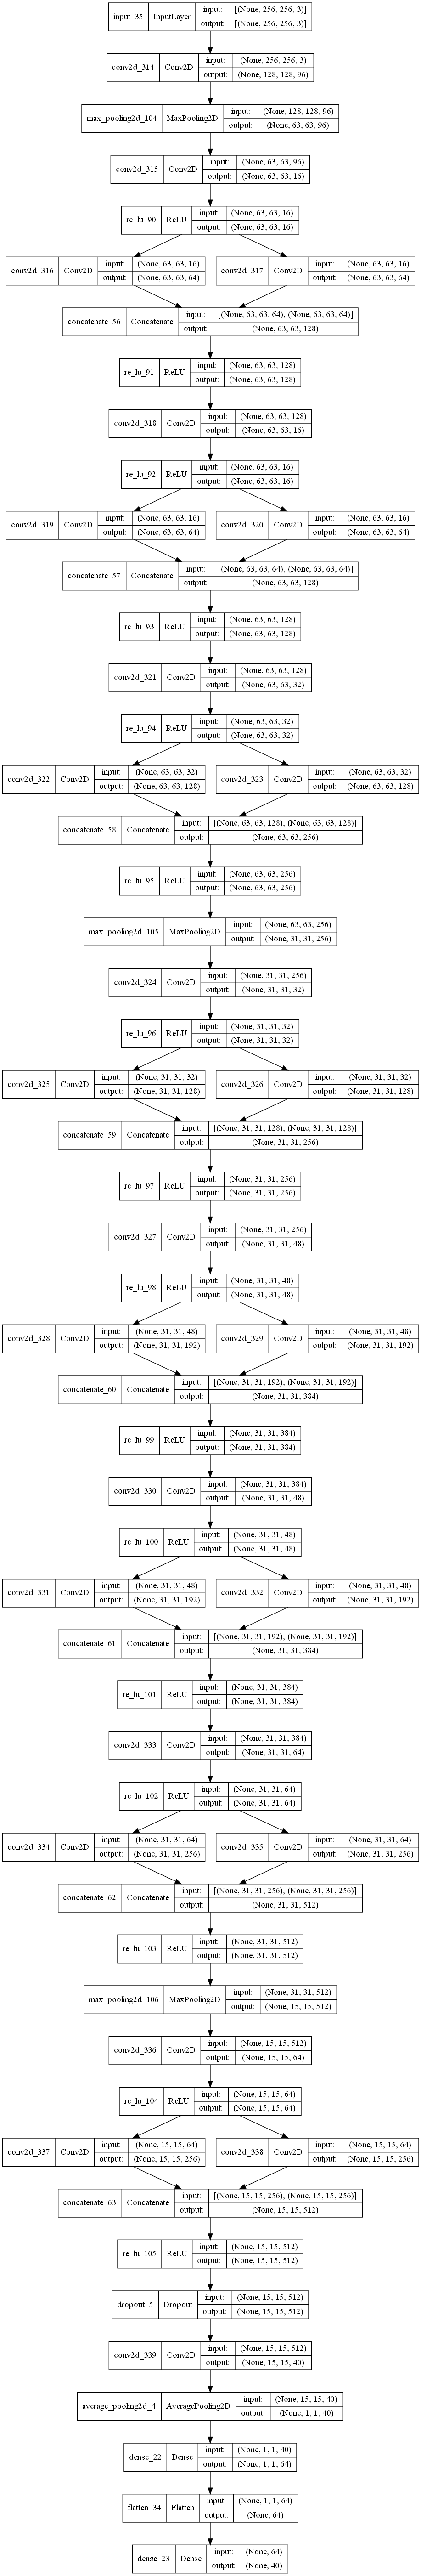

In [ ]:
# plot model architecture
plot_model(model, show_shapes=True, to_file='SqueezeNet.png')

In [ ]:
history = model.fit(mat_train,y_train,batch_size=128,epochs=50,verbose=0,validation_data=(mat_val,y_val))
scores = model.evaluate(mat_test,y_test,verbose=0)
y_score = model.predict(mat_test)
print("%s: %.2f%%" % (model.metrics_names[1],scores[1]*100))

# AlexNet #

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(40, activation='softmax')
])

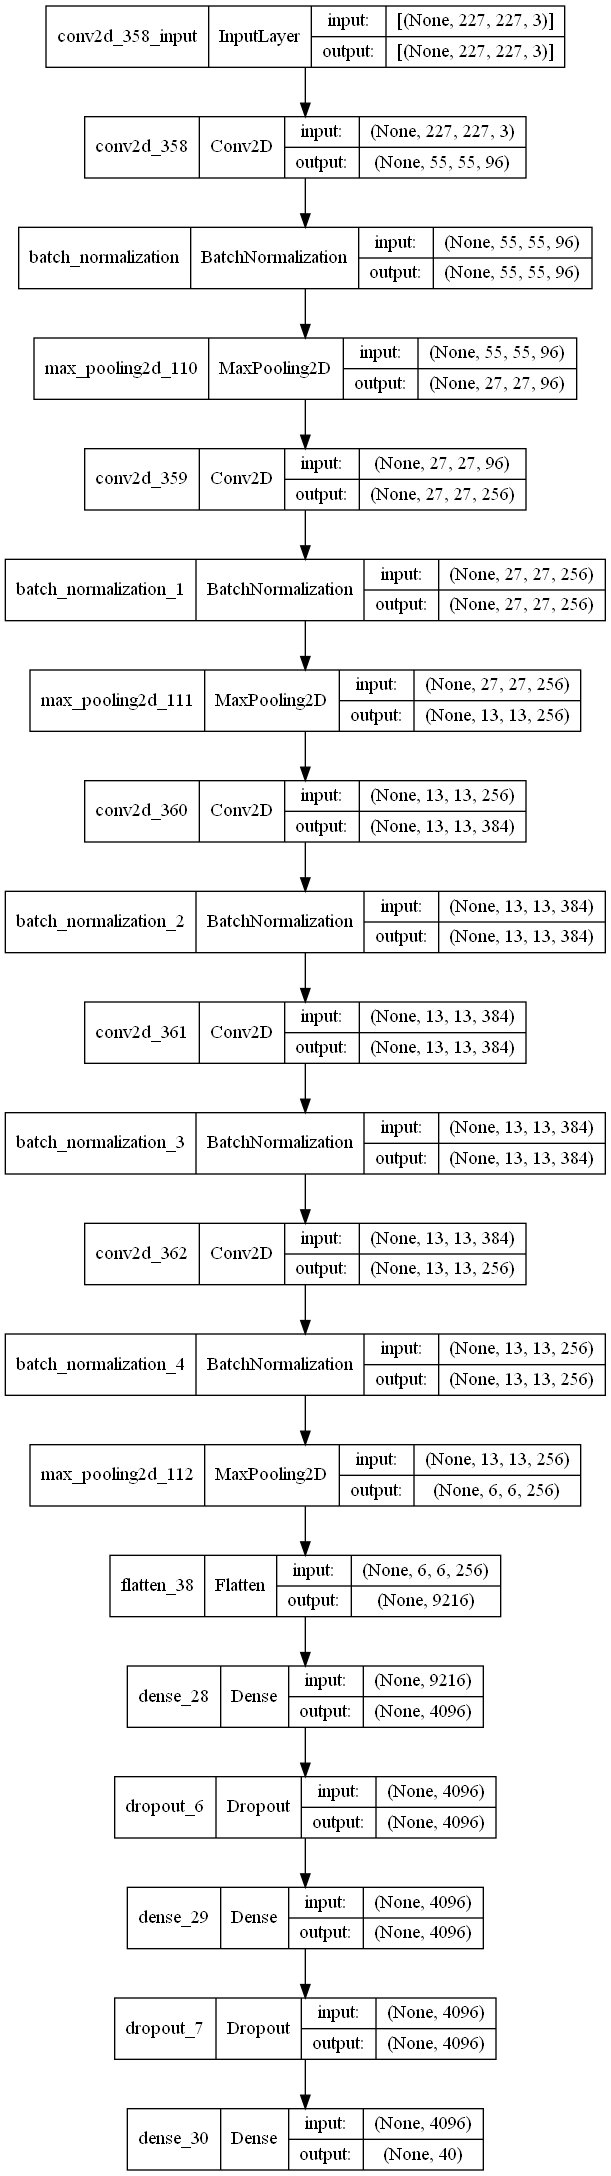

In [ ]:
# plot model architecture
plot_model(model, show_shapes=True, to_file='AlexNet.png')

In [ ]:
history = model.fit(mat_train,y_train,batch_size=128,epochs=50,verbose=0,validation_data=(mat_val,y_val))
scores = model.evaluate(mat_test,y_test,verbose=0)
y_score = model.predict(mat_test)
print("%s: %.2f%%" % (model.metrics_names[1],scores[1]*100))